In [ ]:
#colab is google server its cant see local files ,so it acts as bridge between local files and server to ove from system to colab
from google.colab import files

#After this runs, your file is stored in a folder called /content/
files.upload()

In [ ]:
#mkdir means "make directory" (create a folder). The -p ensures it doesn't crash if the folder already exists. The ~/.kaggle means create a hidden folder named .kaggle in the "home" directory.
!mkdir -p ~/.kaggle #~	Tilde	"The Home Folder" (Where the system keeps user-specific settings).
#.	Dot	"Hidden" (If a file starts with a dot, it is invisible to normal users).
#/	Slash	"Inside" (Used to separate folders).
!cp kaggle.json ~/.kaggle/ #copy kaggle.json into hidden folder
!chmod 600 ~/.kaggle/kaggle.json #change mode,600-Only the owner (you/this notebook) can read or write this file. No one else on the server can touch it."


In [ ]:
# Download dataset
!kaggle datasets download -d crawford/emnist #-d: dataset.compressed .zip file in your current Colab folder.
!unzip emnist.zip -d emnist_data #-d here stands for destination.This line creates a new folder called emnist_data

Dataset URL: https://www.kaggle.com/datasets/crawford/emnist
License(s): CC0-1.0
emnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  emnist.zip
replace emnist_data/emnist-balanced-mapping.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: emnist_data/emnist-balanced-mapping.txt  
  inflating: emnist_data/emnist-balanced-test.csv  
  inflating: emnist_data/emnist-balanced-train.csv  
  inflating: emnist_data/emnist-byclass-mapping.txt  
  inflating: emnist_data/emnist-byclass-test.csv  
  inflating: emnist_data/emnist-byclass-train.csv  
  inflating: emnist_data/emnist-bymerge-mapping.txt  
  inflating: emnist_data/emnist-bymerge-test.csv  
  inflating: emnist_data/emnist-bymerge-train.csv  
  inflating: emnist_data/emnist-digits-mapping.txt  
  inflating: emnist_data/emnist-digits-test.csv  
  inflating: emnist_data/emnist-digits-train.csv  
  inflating: emnist_data/emnist-letters-mapping.txt  
  inflating: emnist_data/emnist-l

In [ ]:
# STEP 2: IMPORT LIBRARIESA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import time

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU FOUND: {gpus[0].name}")
    print("   Training will be FAST!\n")
else:
    print("\n⚠️ NO GPU - Training will be slow (60+ minutes)")
    print("   Go to: Runtime → Change runtime type → T4 GPU\n")



✅ GPU FOUND: /physical_device:GPU:0
   Training will be FAST!



In [ ]:
# STEP 3: LOAD DATA

print("\nLoading EMNIST dataset...")

train_df = pd.read_csv('emnist_data/emnist-balanced-train.csv', nrows=50000)
test_df = pd.read_csv('emnist_data/emnist-balanced-test.csv', nrows=10000)

print(f"✅ Loaded {len(train_df):,} training samples")
print(f"✅ Loaded {len(test_df):,} test samples\n")

# Character classes
CLASSES = ['0','1','2','3','4','5','6','7','8','9',
           'A','B','C','D','E','F','G','H','I','J','K','L','M',
           'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
           'a','b','d','e','f','g','h','n','q','r','t']

print(f"Classes: {len(CLASSES)} characters (0-9, A-Z, some lowercase)\n")


Loading EMNIST dataset...
✅ Loaded 50,000 training samples
✅ Loaded 10,000 test samples

Classes: 47 characters (0-9, A-Z, some lowercase)



In [ ]:
# STEP 4: PREPROCESS DATA



print("\nProcessing images...")

# Extract features and labels
X_train_raw = train_df.iloc[:, 1:].values.reshape(-1, 28, 28)
y_train_raw = train_df.iloc[:, 0].values

X_test_raw = test_df.iloc[:, 1:].values.reshape(-1, 28, 28)
y_test_raw = test_df.iloc[:, 0].values

# Fix EMNIST orientation (images are rotated/flipped)
X_train_raw = np.array([np.rot90(np.fliplr(img)) for img in X_train_raw])
X_test_raw = np.array([np.rot90(np.fliplr(img)) for img in X_test_raw])

# Normalize to 0-1
X_train = X_train_raw.astype('float32') / 255.0
X_test = X_test_raw.astype('float32') / 255.0

# Reshape for CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot
y_train = to_categorical(y_train_raw, len(CLASSES))
y_test = to_categorical(y_test_raw, len(CLASSES))

# Split validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

print(f"✅ Preprocessing complete!")
print(f"   Training: {X_train.shape[0]:,} samples")
print(f"   Validation: {X_val.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples\n")


Processing images...
✅ Preprocessing complete!
   Training: 42,500 samples
   Validation: 7,500 samples
   Test: 10,000 samples



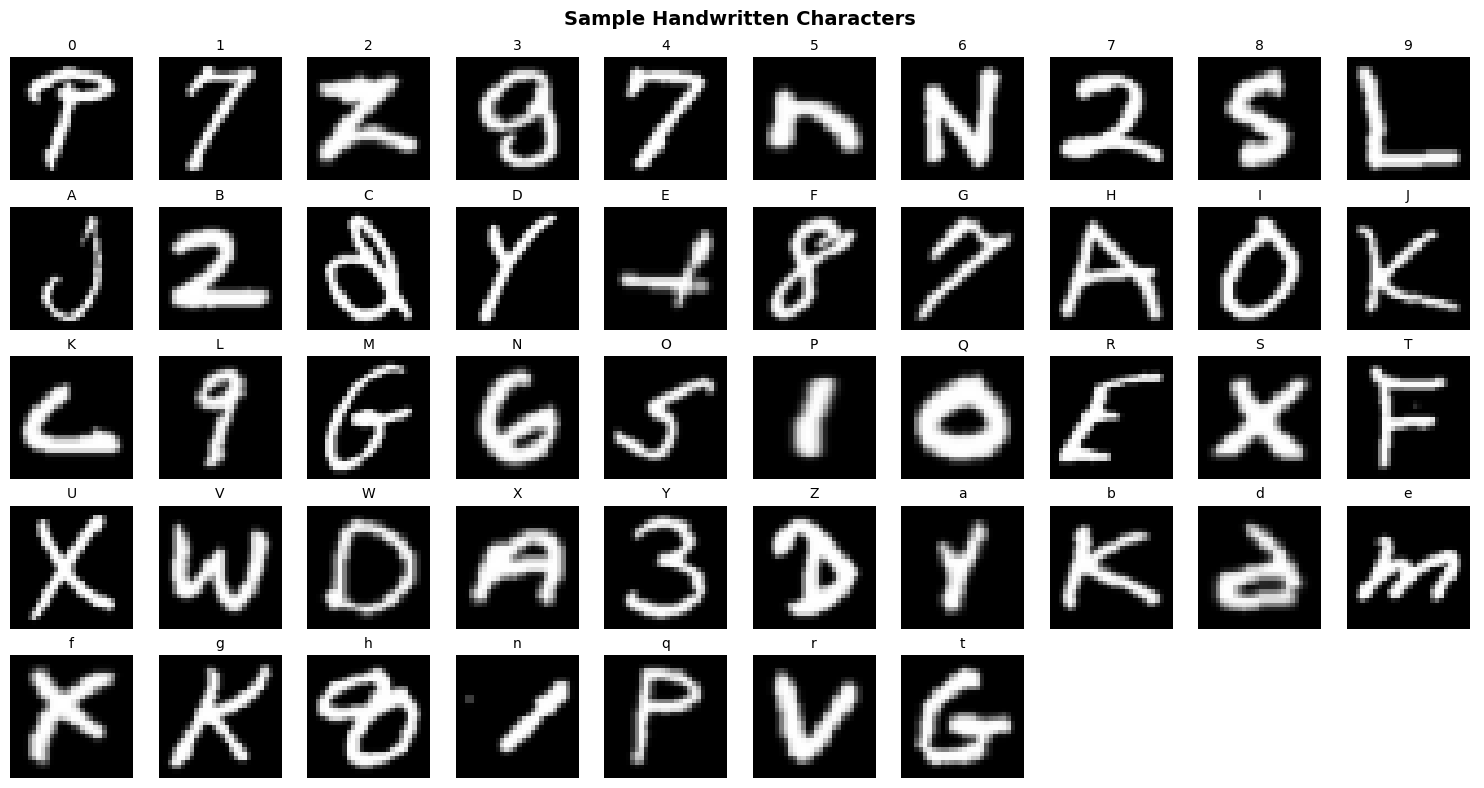


✅ Sample images saved as 'samples.png'



In [ ]:
# STEP 5: VISUALIZE SAMPLES


fig, axes = plt.subplots(5, 10, figsize=(15, 8))
fig.suptitle('Sample Handwritten Characters', fontsize=14, fontweight='bold')

sample_idx = 0
for i in range(len(CLASSES)):
    if sample_idx >= 50:
        break
    # Find first sample of this class
    indices = np.where(y_train_raw[:len(X_train)] == i)[0]
    if len(indices) > 0:
        row = sample_idx // 10
        col = sample_idx % 10
        axes[row, col].imshow(X_train[indices[0]].reshape(28, 28), cmap='gray')
        axes[row, col].set_title(CLASSES[i], fontsize=10)
        axes[row, col].axis('off')
        sample_idx += 1

for i in range(sample_idx, 50):
    axes[i//10, i%10].axis('off')

plt.tight_layout()
plt.savefig('samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Sample images saved as 'samples.png'\n")

In [ ]:
# STEP 6: BUILD MODEL


tf.keras.backend.clear_session()

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✅ Model built with {model.count_params():,} parameters\n")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



✅ Model built with 474,895 parameters



In [ ]:
# STEP 7: TRAIN MODEL

print("\nThis will take 10-15 minutes with GPU (60+ minutes without GPU)")
print("You'll see progress for each epoch below...\n")

start_time = time.time()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = (time.time() - start_time) / 60

print(f"\n✅ Training complete in {training_time:.1f} minutes!\n")



This will take 10-15 minutes with GPU (60+ minutes without GPU)
You'll see progress for each epoch below...

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.1791 - loss: 3.5592 - val_accuracy: 0.0477 - val_loss: 6.7570 - learning_rate: 0.0010
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6072 - loss: 1.2543 - val_accuracy: 0.8016 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7196 - loss: 0.8642 - val_accuracy: 0.8467 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7482 - loss: 0.7850 - val_accuracy: 0.8593 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7833 - loss: 0.6549 - val_accuracy: 0.8696 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7997 - loss: 0.5869 - val_accuracy: 0.8604 - val_loss: 0.

In [ ]:
# STEP 8: EVALUATE MODEL


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)


print(f"FINAL RESULTS:")

print(f"   Test Accuracy:  {test_acc*100:.2f}%")
print(f"   Test Loss:      {test_loss:.4f}")
print(f"   Training Time:  {training_time:.1f} minutes")


if test_acc >= 0.85:
    print("✅ EXCELLENT! Model is working very well!\n")
elif test_acc >= 0.80:
    print("✅ GOOD! Model is performing well!\n")
else:
    print("⚠️ Model could be better. Try training longer..\n")

FINAL RESULTS:
   Test Accuracy:  88.38%
   Test Loss:      0.3289
   Training Time:  1.6 minutes
✅ EXCELLENT! Model is working very well!



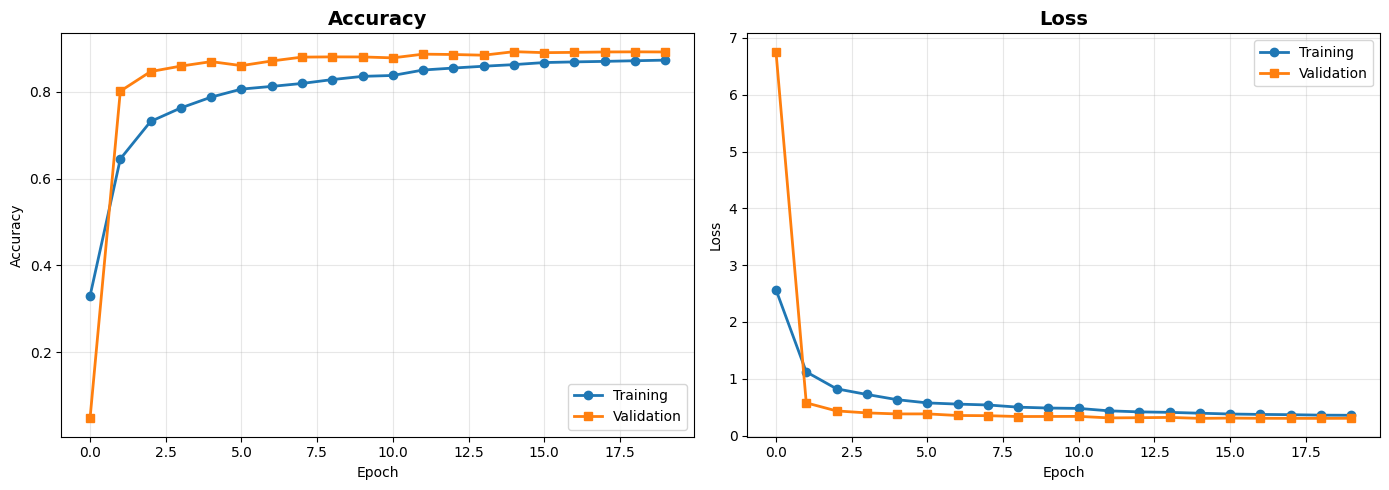


✅ Training history saved as 'training_history.png'



In [ ]:
 #STEP 9: VISUALIZE TRAINING



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], 'o-', label='Training', linewidth=2)
ax1.plot(history.history['val_accuracy'], 's-', label='Validation', linewidth=2)
ax1.set_title('Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], 'o-', label='Training', linewidth=2)
ax2.plot(history.history['val_loss'], 's-', label='Validation', linewidth=2)
ax2.set_title('Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Training history saved as 'training_history.png'\n")


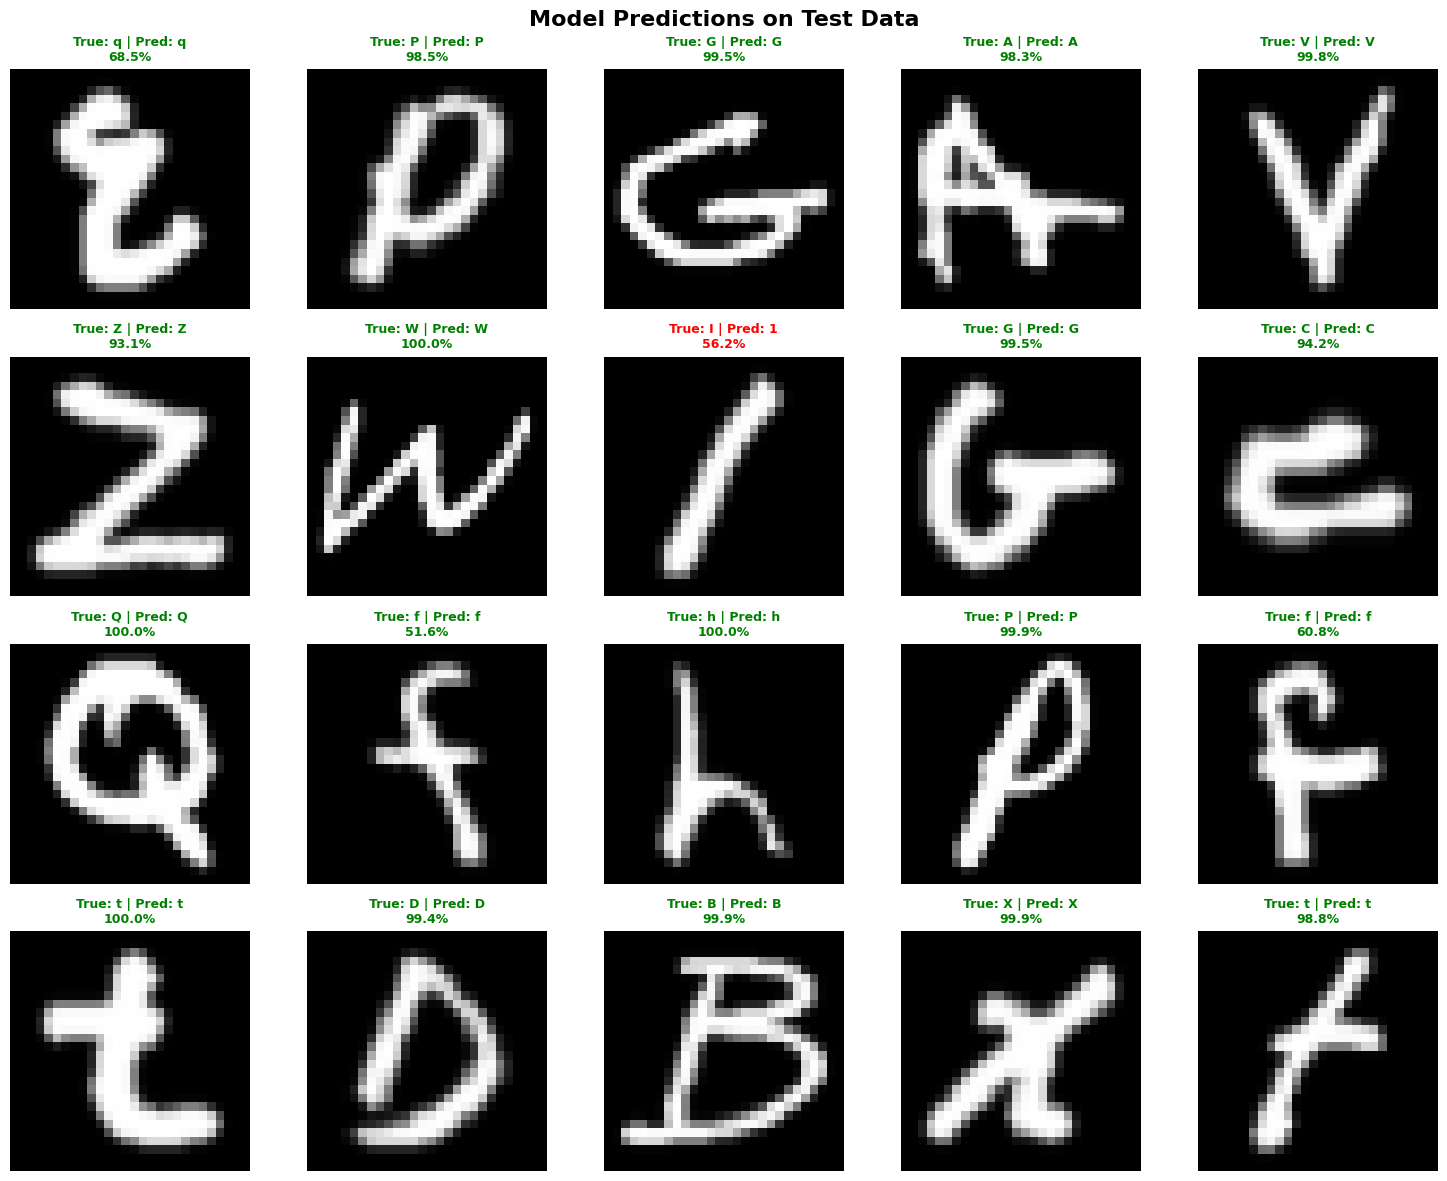


✅ Accuracy on samples: 19/20
✅ Predictions saved as 'predictions.png'



In [ ]:
# STEP 10: TEST PREDICTIONS


n_samples = 20
random_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Model Predictions on Test Data', fontsize=16, fontweight='bold')

correct = 0
for i, (ax, idx) in enumerate(zip(axes.flat, random_indices)):
    image = X_test[idx]
    true_label = np.argmax(y_test[idx])
    true_char = CLASSES[true_label]

    pred = model.predict(image.reshape(1, 28, 28, 1), verbose=0)
    pred_label = np.argmax(pred)
    pred_char = CLASSES[pred_label]
    confidence = np.max(pred) * 100

    is_correct = (pred_char == true_char)
    if is_correct:
        correct += 1

    ax.imshow(image.reshape(28, 28), cmap='gray')
    color = 'green' if is_correct else 'red'
    ax.set_title(f'True: {true_char} | Pred: {pred_char}\n{confidence:.1f}%',
                 color=color, fontweight='bold', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Accuracy on samples: {correct}/{n_samples}")
print(f"✅ Predictions saved as 'predictions.png'\n")

In [ ]:
# STEP 11: SAVE MODEL


model.save('emnist_model.h5')
print("\n✅ Model saved as 'emnist_model.h5'")
print("   (You can download this file to use later)\n")


✅ Model saved as 'emnist_model.h5'
   (You can download this file to use later)




Upload your handwritten character image:
(Write a digit or letter on white paper, take a photo)



Saving u.png to u.png

Processing u.png...


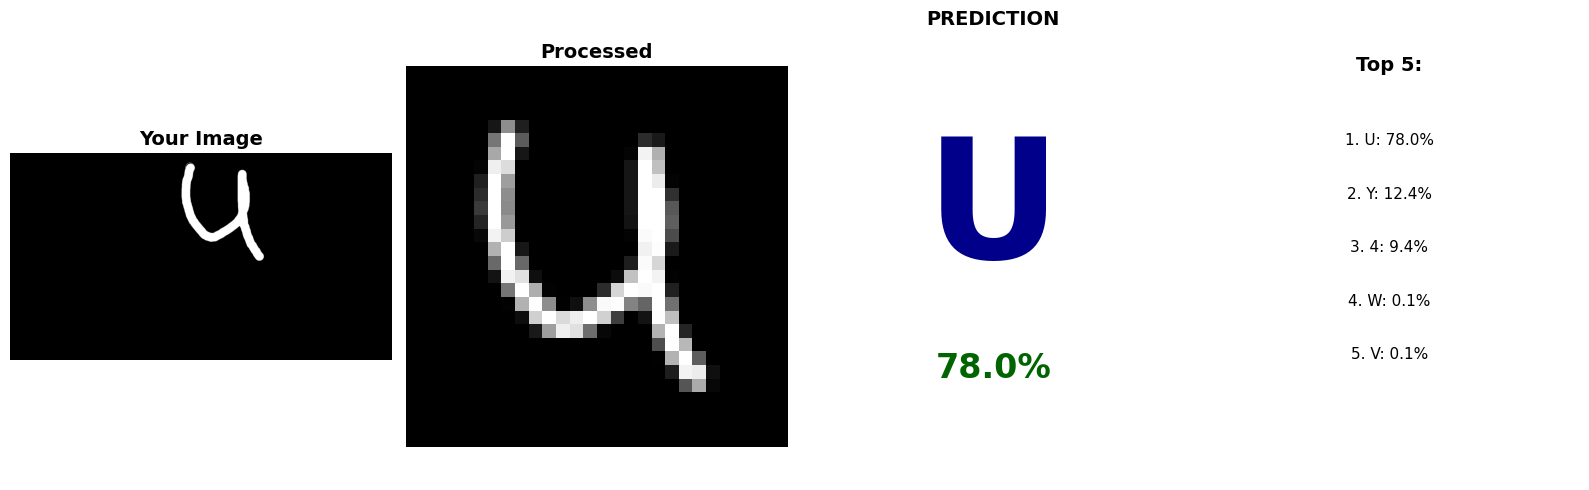


PREDICTION: 'U' with 78.0% confidence

Top 5 predictions:
   1. U: 78.0%
   2. Y: 12.4%
   3. 4: 9.4%
   4. W: 0.1%
   5. V: 0.1%

✅ Result saved as 'my_result.png'



In [ ]:
# STEP 12: TEST YOUR OWN HANDWRITING


from google.colab import files
import io

def preprocess_image(image):
    """Preprocess your handwritten image"""
    # Convert to grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Threshold
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Invert if white background
    if np.mean(image) > 127:
        image = 255 - image

    # Find character
    coords = cv2.findNonZero(image)
    if coords is None:
        return None

    x, y, w, h = cv2.boundingRect(coords)

    # Add padding
    padding = 4
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] - x, w + 2*padding)
    h = min(image.shape[0] - y, h + 2*padding)

    cropped = image[y:y+h, x:x+w]

    # Make square
    size = max(w, h)
    square = np.zeros((size, size), dtype=np.uint8)
    offset_x = (size - w) // 2
    offset_y = (size - h) // 2
    square[offset_y:offset_y+h, offset_x:offset_x+w] = cropped

    # Resize to 20x20
    resized = cv2.resize(square, (20, 20), interpolation=cv2.INTER_AREA)

    # Add border to make 28x28
    final = np.zeros((28, 28), dtype=np.uint8)
    final[4:24, 4:24] = resized

    # Normalize
    normalized = final.astype('float32') / 255.0

    return normalized.reshape(1, 28, 28, 1)

print("\nUpload your handwritten character image:")
print("(Write a digit or letter on white paper, take a photo)\n")

uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"\nProcessing {filename}...")

    img = Image.open(io.BytesIO(uploaded[filename]))
    img_array = np.array(img)

    processed = preprocess_image(img_array)

    if processed is None:
        print("❌ Could not detect character. Try a clearer image!")
    else:
        # Predict
        pred = model.predict(processed, verbose=0)
        pred_idx = np.argmax(pred)
        pred_char = CLASSES[pred_idx]
        confidence = pred[0][pred_idx] * 100

        # Top 5
        top5_idx = np.argsort(pred[0])[-5:][::-1]
        top5_chars = [CLASSES[i] for i in top5_idx]
        top5_confs = [pred[0][i] * 100 for i in top5_idx]

        # Display
        fig = plt.figure(figsize=(16, 5))

        ax1 = plt.subplot(1, 4, 1)
        if len(img_array.shape) == 3:
            ax1.imshow(img_array)
        else:
            ax1.imshow(img_array, cmap='gray')
        ax1.set_title('Your Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        ax2 = plt.subplot(1, 4, 2)
        ax2.imshow(processed.reshape(28, 28), cmap='gray')
        ax2.set_title('Processed', fontsize=14, fontweight='bold')
        ax2.axis('off')

        ax3 = plt.subplot(1, 4, 3)
        ax3.text(0.5, 0.6, pred_char, fontsize=120, ha='center', va='center',
                fontweight='bold', color='darkblue')
        ax3.text(0.5, 0.25, f'{confidence:.1f}%', fontsize=24,
                ha='center', va='center', color='darkgreen', fontweight='bold')
        ax3.set_title('PREDICTION', fontsize=14, fontweight='bold')
        ax3.axis('off')
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)

        ax4 = plt.subplot(1, 4, 4)
        ax4.text(0.5, 0.95, 'Top 5:', fontsize=14, ha='center', va='top', fontweight='bold')
        for i, (c, cf) in enumerate(zip(top5_chars, top5_confs)):
            y = 0.75 - i * 0.12
            ax4.text(0.5, y, f'{i+1}. {c}: {cf:.1f}%', fontsize=11, ha='center')
        ax4.axis('off')
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig('my_result.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"\n{'='*70}")
        print(f"PREDICTION: '{pred_char}' with {confidence:.1f}% confidence")
        print(f"{'='*70}")
        print(f"\nTop 5 predictions:")
        for i, (c, cf) in enumerate(zip(top5_chars, top5_confs)):
            print(f"   {i+1}. {c}: {cf:.1f}%")
        print(f"\n✅ Result saved as 'my_result.png'\n")

In [ ]:

# DEPLOYMENT PREPARATION


# 1. SAVE THE TRAINED MODEL
print("\n1️⃣ Saving model...")
model.save('handwriting_model.h5')
print("   ✅ Model saved as 'handwriting_model.h5'")



1️⃣ Saving model...
   ✅ Model saved as 'handwriting_model.h5'


In [ ]:
# 2. SAVE THE CLASS LABELS
print("\n2️⃣ Saving class labels...")
import pickle
with open('classes.pkl', 'wb') as f:
    pickle.dump(CLASSES, f)
print("   ✅ Classes saved as 'classes.pkl'")


2️⃣ Saving class labels...
   ✅ Classes saved as 'classes.pkl'


In [ ]:
# 4. DOWNLOAD ALL FILES
print("\n4️⃣ Downloading files to your computer...")
from google.colab import files

files.download('handwriting_model.h5')
files.download('classes.pkl')
files.download('preprocessing_reference.txt')


print("\nYou should now have 3 files downloaded:")
print("  1. handwriting_model.h5 (your trained model)")
print("  2. classes.pkl (character labels)")
print("  3. preprocessing_reference.txt (for reference)")




4️⃣ Downloading files to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


You should now have 3 files downloaded:
  1. handwriting_model.h5 (your trained model)
  2. classes.pkl (character labels)
  3. preprocessing_reference.txt (for reference)
